# Module 13: Pose Estimation with OpenPose  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1jb_7r_Eo1CuuwKgF6A1nGujSBO-qRrk4?usp=sharing)


## Overview

This notebook demonstrates how to perform 2D human pose estimation using a pre-trained OpenPose model and OpenCV's deep learning module. Pose estimation is the process of identifying and localizing key human body joints (like the head, shoulders, elbows, knees, etc.) in an image or video. These joints, or keypoints, are then connected to form a skeletal structure.

Pose estimation is widely used in:
- Human-computer interaction
- Sports analytics
- Augmented reality
- Fitness applications
- Activity recognition and gesture detection

## What You'll Learn

- How to load and use a Caffe-based OpenPose model in OpenCV
- How to preprocess images for deep learning inference
- How to interpret the model output (confidence maps)
- How to extract and visualize detected body keypoints
- How to draw a skeleton over the detected pose

## Tools Used

- **OpenCV (`cv2.dnn`)**: for image processing and running the deep learning model
- **Pre-trained OpenPose Caffe model**: detects 15 human body keypoints
- **Matplotlib**: to visualize input, output, and skeleton overlays

This implementation is image-based (not video-based) and beginner-friendly, intended for anyone with basic Python and OpenCV knowledge. No prior experience with pose estimation is required.





## Step 1: Import Required Libraries

We start by importing OpenCV for image and video operations, Matplotlib for visualizing output, and NumPy for numerical computations.


In [ ]:
#Importing Libraries
import cv2
import matplotlib.pyplot as plt
import numpy


## Step 2: Load and Convert the Input Image

We read the input image using `cv2.imread()`, which loads it in BGR format (OpenCV default). Since Matplotlib expects RGB format, we convert the image using `cv2.cvtColor()`.

Finally, we display the image using `plt.imshow()` and remove axis labels for a cleaner look.


(np.float64(-0.5), np.float64(841.5), np.float64(843.5), np.float64(-0.5))

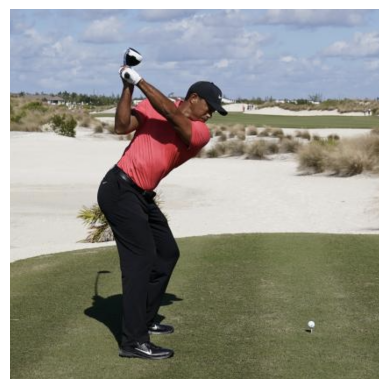

In [ ]:
#Reading and convertion image from
image=cv2.imread('Tiger_Woods_crop.png')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.axis('off')

## Step 3: Load Pre-trained Model

We use a pre-trained Caffe model for human pose estimation.

OpenCV’s `cv2.dnn.readNetFromCaffe()` loads the model using:
- A `.prototxt` file: defines the network architecture
- A `.caffemodel` file: contains the trained weights

**Download link**:  
[Weights / Caffe Model](https://huggingface.co/camenduru/openpose/resolve/f4a22b0e6fa2a4a2b1e2d50bd589e8bb11ebea7c/pose_iter_160000.caffemodel)


In [ ]:
#Loading Caffe Moel and prototext
net=cv2.dnn.readNetFromCaffe('pose_deploy_linevec_faster_4_stages.prototxt','pose_iter_160000.caffemodel')

## Step 4: Define Keypoints and Skeleton Connections

`n_points` is the number of keypoints the model can detect. This depends on the specific OpenPose version being used. Here, we use 15 keypoints.

`pose_pairs` defines how keypoints are connected to form the skeleton. Each pair connects two body parts and will be used to draw the pose lines.


In [ ]:
# Number of keypoints in the model
n_points = 15  # Based on the specific OpenPose model you're using

# Pose pairs are the connections between keypoints for drawing the skeleton
pose_pairs = [
    [0, 1], [1, 2], [2, 3], [3, 4],
    [1, 5], [5, 6], [6, 7],
    [1, 14], [14, 8], [8, 9], [9, 10],
    [14, 11], [11, 12], [12, 13]
]

##Step 5 Getting Image Dimensions
###  Understanding `image.shape` in OpenCV

Even though we're working with OpenCV (`cv2`), the image object it loads is actually a **NumPy array**.




In [ ]:
#As opencv have convention widt and heigh not height and width
width=image.shape[0]
height=image.shape[1]
image.shape #844=width and 842=height and 3 =color channels

(844, 842, 3)

## Step 6: Create Input Blob

We convert the image into a blob using `cv2.dnn.blobFromImage()`. A blob is a preprocessed image that can be passed into the neural network.

- `scalefactor=1/255`: Normalizes pixel values from 0–255 to 0–1.
- `size=(368, 368)`: Resizes the image to the size expected by the model.
- `mean=(0, 0, 0)`: No mean subtraction applied.
- `swapRB=True`: Converts image from BGR (OpenCV default) to RGB.
- `crop=False`: The image is resized without cropping.

Finally, we pass the blob as input to the network using `net.setInput(blob)`.


In [ ]:
#Creating Blob
blob=cv2.dnn.blobFromImage(image,
                           scalefactor=1/255, # Normalizes image to 0-1 range; Neural networks (especially deep CNNs like OpenPose) often expect inputs in the range 0.0–1.0.
                           size=(368,368),#Caffemodel here is trained on 368x368 pixel images
                           mean=(0,0,0),#No mean substaction is needed
                           swapRB=True,#Using a downloaded images so swap is needed
                           crop=False)#Resize is neede hence crop is false
net.setInput(blob)


## Step 7: Forward Pass

We run a forward pass with `net.forward()` to get the model output. This gives us confidence maps for each keypoint.

Each confidence map is a 2D array showing the probability of a specific keypoint (e.g., nose, elbow) being present at each location in the image.

To visualize:
- We resize each keypoint’s confidence map to match the image size.
- We display them using Matplotlib with a color heatmap (`cmap='jet'`).
- `plt.subplot()` is used to arrange the maps in a grid.


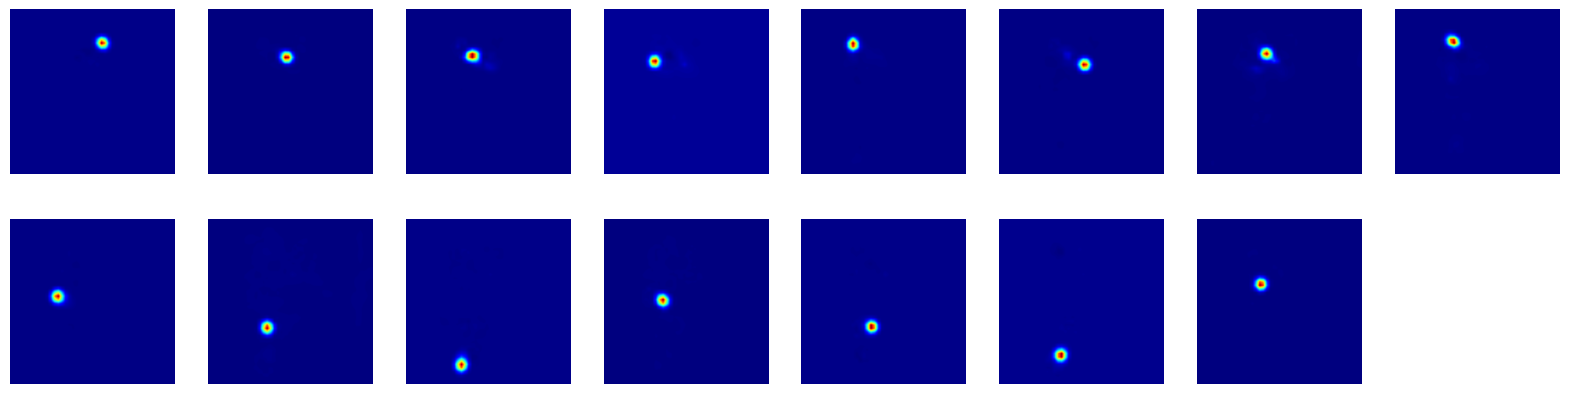

In [ ]:
output=net.forward()

#Displaying the npints and which points they represents
plt.figure(figsize=(20,5))

for i in range(n_points):

  map=output[0,i,:,:] # We're not detecting keypoints yet — just visualizing the confidence heatmap for keypoint index 'i'
# output[0, i, :, :] → 2D map showing likelihood of keypoint 'i' being at each (x, y) position

  display_map=cv2.resize(map,dsize=(width,height),interpolation=cv2.INTER_LINEAR) # width & height are the input width and height
  plt.subplot(2,8,i+1);plt.axis('off') #i+1 beacuse matplotlib index starts from 1 not 0
  plt.imshow(display_map,cmap='jet')


## Step 8: Extract Keypoints from Confidence Maps

The model output is a 4D array of shape `(1, n_points, output_height, output_width)`. To map these to the original image size, we calculate scaling factors:

- `scale_X = input_width / output_width`
- `scale_Y = input_height / output_height`

### Note on Dimensions:
Even though OpenCV usually uses (width, height) order, `output.shape[2]` is **height** and `output.shape[3]` is **width** — because NumPy follows (batch, channels, height, width).

---

### Thresholding Keypoints:

We set a threshold (0.1) to ignore low-confidence predictions. For each keypoint:

- We extract its probability map (`proba_map = output[0, i, :, :]`)
- Use `cv2.minMaxLoc()` to find the **location with the highest confidence** for that keypoint

---

### Explanation of `cv2.minMaxLoc()`:

`cv2.minMaxLoc()` returns four values from a 2D array:

- `min_val`: Minimum value in the map
- `max_val` (`prob`): Maximum value (confidence for the keypoint)
- `min_loc`: Location of the min value
- `max_loc` (`point`): Location of the max value (most likely keypoint position)

We use `max_loc` to get the keypoint position and scale it back to the original image size.

Only keypoints with confidence above the threshold are added to the `points` list; others are stored as `None`.


In [ ]:
output.shape
#width and heightsarethe input image width and height while out.shape[2] and output.shape[3] are output heights and width
scale_X=width/output.shape[3]
scale_y=height/output.shape[2]
#Do not get confused as index 2 does tell heigh and 3 width  the order for ocv althoug is width and height so order changed

#Threshold to detect the key points
threshold=0.1
#Empty list for appending the keypoints
points =[]

for i in range(n_points):
  proba_map=output[0,i,:,:]

  #using minmax algo to find the max probability of keypoints in output
  min_val,prob,min_loc,point=cv2.minMaxLoc(proba_map)

  x=scale_X * point[0] #width #
  y=scale_y * point[1]#height

  if prob > threshold:
    points.append((int (x),int (y)))
  else:
    points.append(None)



## Step 9: Draw the Pose Skeleton

Using the detected keypoints and defined `pose_pairs`, we draw the human skeleton on top of the original image.

- For each pair of connected keypoints:
  - If both points exist (not `None`), draw a line between them
  - Also draw a circle on the first point in the pair
  - `cv2.line()` is used to connect joints
  - `cv2.circle()` is used to mark each joint

The output is displayed using Matplotlib with the same aspect ratio as the original image.


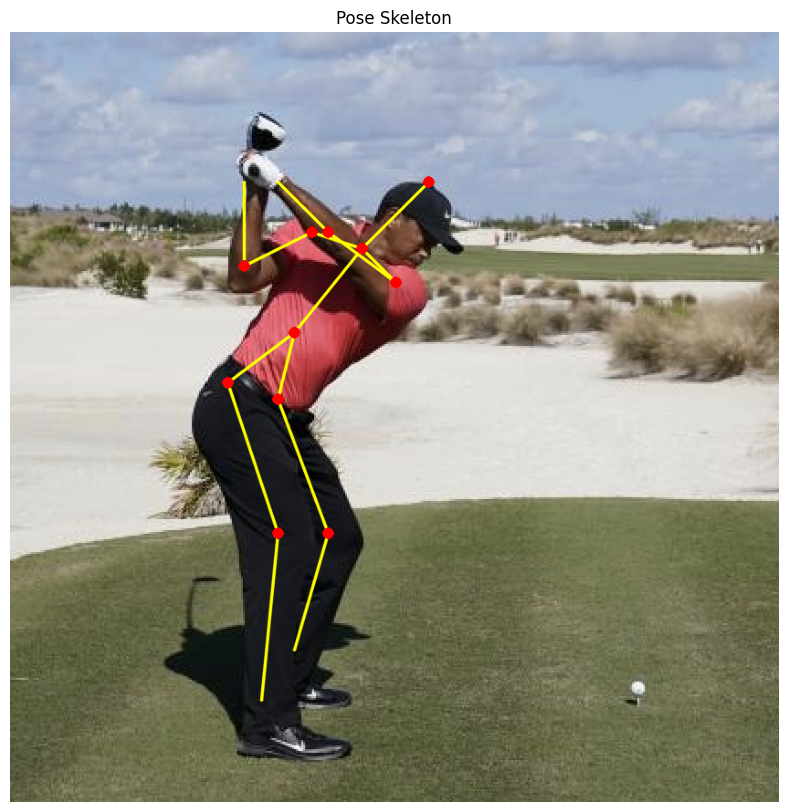

In [ ]:
#Display Skeleton:

skeleton=image.copy()

for pair in pose_pairs:
  part_a=pair[0]
  part_b=pair[1]

  if points[part_a] and points[part_b]:
    cv2.line(skeleton,points[part_a],points[part_b],color=(255,255,0),thickness=2,lineType=cv2.LINE_AA)
    cv2.circle(skeleton,points[part_a],radius=6,color=(255,0,0),thickness=-2,lineType=cv2.FILLED)

#Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(skeleton, aspect='equal')  # Keeps original aspect ratio
plt.axis('off')
plt.title("Pose Skeleton")
plt.show()



##  Navigation

[![➡️ Module 12](https://img.shields.io/badge/Module-12-000000?style=for-the-badge&logo=github&logoColor=00FF80)](https://github.com/aypy01/opencv/tree/main/12)
&nbsp;&nbsp;&nbsp;&nbsp;


---
#Thanking Note
 Thanks for scrolling this far.

If this notebook helped you see joints where once there were only pixels , my mission accomplished.

The code works... mostly. But if it ever doesn’t:  

***“These notebooks runs. Until it doesn't. Then it was your turn to suffer.”***


Welcome to the edge of the OpenCV.  
Your next move: fork, break, improve, repeat.

— Aaditya Yadav 🟢🟣


[![➡️ Credit ](https://img.shields.io/badge/Credits-000000?style=for-the-badge&logo=github&logoColor=00FF80)](https://github.com/aypy01/opencv/tree/main/01)
&nbsp;&nbsp;&nbsp;&nbsp;


---



## Author
 <p align="left">
  Created and maintained by
  <a href="https://github.com/aypy01" target="_blank">&nbsp Aaditya Yadav</a>&nbsp
  <a href="https://github.com/aypy01" target="_blank">
    <img src="https://img.shields.io/badge/aypy01-000000?style=flat-square&logo=github&logoColor=00FF80" alt="GitHub Badge"/>
  </a>
</p>

</p>
<p align="left">
  <img src="https://readme-typing-svg.demolab.com?font=Fira+Code&duration=3000&pause=500&color=00FF80&center=false&vCenter=false&width=440&lines=Break+Things+First%2C+Understand+Later;Built+to+Debug%2C+Not+Repeat;Learning+What+Actually+Sticks;Code.+Observe.+Refine." alt="Typing SVG" />
</p>

---




##  License

This project is licensed under the [![License: Apache 2.0](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0).